# Seattle AirBnB analysis - using CRISP-DM process

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import calendar
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from time import time
from sklearn.metrics import accuracy_score, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['calendar.csv', 'listings.csv', 'reviews.csv']


## **CRISP-DM (Cross-Industry Standard Process for Data Mining)**
### Business Understanding
 * Understand the business drivers of the analysis to ensure value is provided in the correct focus areas. This involves understanding the business context and domain. 
 
### Data Understanding
 * Collect data, describe data and explore data. Usually includes checking for data quality issues and getting clarity around what data is available and what is not available.

### Data Preparation
 * Select data, clean data, dervie/generate new data fields, and integrate data. The output will be data sets ready for use in analysis and modelling.

### Modeling
 * Select modelling technique (simple or complex), build model and assess model.

### Evaluation
 * Evaluate degree to which the model meets business aims and answers the business questions posed. Ideally, we want to draw conclusions related to the questions posed. Plan for potential future steps.

### Deployment
 * Determine a strategy for deployment. Goes into the realms of operationalising models for the business.

## **Business understanding**

This step involves learning more about the business domain we are working on. Subsequently, this enables us to ask questions that will help us improve our understanding of the domain.

Airbnb is an online platform that connects travellers looking for accommodation to hosts of spaces available for rent.

In this analysis, we will be using Seattle Airbnb data. In order to set the scene, let's assume that we are looking to buy an investment property in Seattle. We are intending to rent out the property through Airbnb and maximise our revenue returns from rental income. Guided by that, we are interested in learning more about the following: 

> **1. What are the highest revenue generating locations for Seattle hosts?**
 * We are keen to find out the best neighbourhood to buy the property. 
 
> **2. When in the year are the highest revenues generated? **
 * Knowing the time of the year that drives the most revenue will enable us to vary prices to maximise revenue at those times.

> **3. What are the property traits that attract the highest revenues? ** 
 * It is beneficial to purchase a property with characteristics that are in high demand.

## **Data understanding**

This step involves learning more about the data available for the business domain we are working on. The aim here is to see what data is available, look for high level characteristics and patterns in the data through summarisations, aggregations and visualisations.

Base on the questions posed above, the key data points required are:
1. **Price**
 > - **Fields in the data (listings)**: 'price', 'weekly_price', 'monthly_price'

2. **Revenue**
 > - **Join (listings) and (calendar)**: Assume that if a property is not available, it has been rented out at the daily price provided in the (listings) dataset
 > - **Revenue for a given day** = [if(calendar.available == 'f') then 1, else 0] * [listings.price] 
 > - **Average revenue for a property** = ([if(calendar.available == 'f') then 1, else 0] * [listings.price]) / sum([if(calendar.available == 'f') then 1, else 0])
 
3. **Location**
 > - **Fields in the data (listings)**: 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location'

4. **Listing date**
 > - **Fields in the data (calendar)**: 'date'

5. **Property characteristics: Building type, building size, bedroom count, bed count, bed type, bathroom count, room type**  
 > - **Fields in the data (listings)**: 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet'

6. **Joining all 3 datasets**
 > - **Fields in the data (listings)**: 'id'
 > - **Fields in the data (calendar)**: 'listing_id'
 > - **Fields in the data (reviews)**: 'listing_id'

With this preliminary data knowledge, we will be able to hone into the data sets that we will need and focus our data preparation and cleaning efforts on them.

In [2]:
# Read in data into data frames
listings = pd.read_csv('../input/listings.csv') 
calendar = pd.read_csv('../input/calendar.csv')
reviews = pd.read_csv('../input/reviews.csv')

In [3]:
# Quick look at data - listings

# Rows and columns count
print(listings.shape)

print('-'*90)

# List of the columns available
print(list(listings.columns))

# Sample
listings.head(5)

(3818, 92)
------------------------------------------------------------------------------------------
['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenitie

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

In [4]:
# Check for missing values in the columns for each dataset- returning missing value as a percentage
(listings.isnull().sum()/len(listings)*100).sort_values(ascending=False)

license                             100.000000
square_feet                          97.459403
monthly_price                        60.267156
security_deposit                     51.126244
weekly_price                         47.380828
notes                                42.063908
neighborhood_overview                27.029859
cleaning_fee                         26.977475
transit                              24.463070
host_about                           22.498690
host_acceptance_rate                 20.246202
review_scores_accuracy               17.234154
review_scores_checkin                17.234154
review_scores_value                  17.181771
review_scores_location               17.155579
review_scores_cleanliness            17.103195
review_scores_communication          17.050812
review_scores_rating                 16.946045
reviews_per_month                    16.422211
first_review                         16.422211
last_review                          16.422211
space        

In [5]:
# List columns with greater than 30% null values 
[cols for cols in listings.columns.values if (listings[cols].isnull().sum()/len(listings)*100)>=30]

['notes',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'license']

In [6]:
# Now that we have had a look at the original listings data set, we can proceed to gaining more focused insights

# Based on the questions that we are looking to answer, create a listings data set containing only fields/features that are useful
listings_relevant = listings[['id'
                              , 'price'
                              , 'weekly_price'
                              , 'monthly_price'
                              , 'street'
                              , 'neighbourhood'
                              , 'neighbourhood_cleansed'
                              , 'neighbourhood_group_cleansed'
                              , 'city'
                              , 'state'
                              , 'zipcode'
                              , 'market'
                              , 'smart_location'
                              , 'property_type'
                              , 'room_type'
                              , 'accommodates'
                              , 'bathrooms'
                              , 'bedrooms'
                              , 'beds'
                              , 'bed_type'
                              , 'amenities'
                              , 'square_feet'
                             ]]

# Quick look at data - listings_relevant
print(listings_relevant.shape)

print('-'*90)

# List of the columns available
print(list(listings_relevant.columns))

# Sample of table
listings_relevant.head(5)

(3818, 22)
------------------------------------------------------------------------------------------
['id', 'price', 'weekly_price', 'monthly_price', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']


,id,price,weekly_price,monthly_price,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
0,241032,$85.00,NaN,NaN,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN
1,953595,$150.00,"$1,000.00","$3,000.00","7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN
2,3308979,$975.00,NaN,NaN,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN
3,7421966,$100.00,$650.00,"$2,300.00","8th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN
4,278830,$450.00,NaN,NaN,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN


In [7]:
# Check for missing values in the columns for each dataset- returning missing value as a percentage
(listings_relevant.isnull().sum()/len(listings_relevant)*100).sort_values(ascending=False)

square_feet                     97.459403
monthly_price                   60.267156
weekly_price                    47.380828
neighbourhood                   10.895757
bathrooms                        0.419068
zipcode                          0.183342
bedrooms                         0.157150
property_type                    0.026192
beds                             0.026192
accommodates                     0.000000
room_type                        0.000000
smart_location                   0.000000
market                           0.000000
amenities                        0.000000
state                            0.000000
city                             0.000000
neighbourhood_group_cleansed     0.000000
neighbourhood_cleansed           0.000000
street                           0.000000
bed_type                         0.000000
price                            0.000000
id                               0.000000
dtype: float64

In [8]:
# List columns with greater than 30% null values 
[cols for cols in listings_relevant.columns.values if (listings_relevant[cols].isnull().sum()/len(listings_relevant)*100)>=30]

# These columns will be removed as there are too many null values to properly impute values in place of nulls
# Additionally, there are also other fields that can be used to provide similar information: such as 'weekly_price' and 'monthly_price' provides same information as 'price'
    

['weekly_price', 'monthly_price', 'square_feet']

In [9]:
# Quick look at data - calendar
print(calendar.shape)

print('-'*90)

# List of the columns available
print(list(calendar.columns))

# Sample of table
calendar.head(30)

(1393570, 4)
------------------------------------------------------------------------------------------
['listing_id', 'date', 'available', 'price']


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [10]:
# Check if the property is not available - what are the variety of 'prices' available
calendar[calendar['available'] == 'f']['price'].unique()

array([nan], dtype=object)

In [11]:
# Quick look at unique calendar values to gauge data date range
print(calendar['date'].nunique())

calendar['date'].unique()

365


array(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
       '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11',
       '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15',
       '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19',
       '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23',
       '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27',
       '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31',
       '2016-02-01', '2016-02-02', '2016-02-03', '2016-02-04',
       '2016-02-05', '2016-02-06', '2016-02-07', '2016-02-08',
       '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12',
       '2016-02-13', '2016-02-14', '2016-02-15', '2016-02-16',
       '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-20',
       '2016-02-21', '2016-02-22', '2016-02-23', '2016-02-24',
       '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28',
       '2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03',
       '2016-03-04', '2016-03-05', '2016-03-06', '2016-

In [12]:
# Check for missing values in the columns for each dataset- returning missing value as a percentage
(calendar.isnull().sum()/len(calendar)*100).sort_values(ascending=False)

price         32.938998
available      0.000000
date           0.000000
listing_id     0.000000
dtype: float64

In [13]:
# Now that we have had a look at the original calendar data set, we can proceed to gaining more focused insights

# Based on the questions that we are looking to answer, create a calendar data set containing only fields/columns and records that are useful
calendar_relevant = calendar[calendar['available'] == 'f']
calendar_relevant = calendar_relevant[['listing_id'
                                      , 'date'
                                      , 'available'
                                     ]]

# Quick look at data - calendar_relevant
print(calendar_relevant.shape)

print('-'*90)

# List of the columns available
print(list(calendar_relevant.columns))

# Sample of table
calendar_relevant.head(5)

(459028, 3)
------------------------------------------------------------------------------------------
['listing_id', 'date', 'available']


,listing_id,date,available
2,241032,2016-01-06,f
3,241032,2016-01-07,f
4,241032,2016-01-08,f
5,241032,2016-01-09,f
6,241032,2016-01-10,f


In [14]:
# Quick look at data - reviews
print(reviews.shape)

print('-'*90)

# List of the columns available
print(list(reviews.columns))

# Sample data view 
reviews.head()

(84849, 6)
------------------------------------------------------------------------------------------
['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [15]:
# Check for missing values in the columns for each dataset- returning missing value as a percentage
(reviews.isnull().sum()/len(reviews)*100).sort_values(ascending=False)

comments         0.021214
reviewer_name    0.000000
reviewer_id      0.000000
date             0.000000
id               0.000000
listing_id       0.000000
dtype: float64

From the quick checks above, we can make the following observations about each dataset.

### listings
- The raw dataset has (3818 rows, 92 columns/fields)
- Based on the business questions we are trying to answer, we then create a 'listings_relevant' dataset focusing on 22 columns/fields
    - 3 fields ('square_feet', 'monthly_price', 'weekly_price') have greater than 30% null values
        - 'square_feet' is useful to determine a key property characteristic, which is the size of the property. Given the substantial number of null values, we will disregard it as it would be inaccurate to impute.
        - 'monthly_price', 'weekly_price' fields can be disregarded as they provide approximately the same information as 'price'(daily price). For the purposes of our analysis, we will disregard the effects of bulk discounts and focus on non-discounted daily prices.  


### calendar 
- The raw dataset has (1393570 rows, 4 columns/fields)
- There are 365 unique date values
- Based on the business questions, all fields are relevant, however from a records perspective, we are only interested in records where 'available' = 'f' (the property is unavailable, presumably as it has been rented out at the daily rate provided in the listings data set). This is as to calculate revenue, we only need data relating to when the property has been rented out. Thus, we create a 'calendar_relevant' dataset with that filter.
    - The 'price' field has greater than 30% null values. However, we will be using price information from the 'listings' dataset instead. Additionally, when 'available' = 'f', there are no prices. Therefore, we will drop this field.
    - We calculate 'revenue' by assuming that if a property is not 'available' for a given 'date', it is being rented out at the daily 'price' in the 'listings' dataset.
    
    
### reviews
- The raw dataset has (84849 rows, 6 columns/fields)
- Based on the business questions, we are not going to need this dataset. However, it will be useful for future use.

## **Data preparation**

This step involves preparing the dataset for analysis and modelling - en route to answering the business questions.

### High level preparation steps to be performed:
#### Clean the (listings_relevant) dataset --> Output: (listings_relevant_clean) dataset
 - Drop fields with > 30% null values
 - Convert 'price' from string into numeric float ('price_clean')
     - Drop original 'price' field
 - Explore property/building type related data
     - Fields covered: ['property_type', 'room_type', 'bed_type', 'accommodates','bathrooms','bedrooms','beds']
 - Clean property/building type related data     
     - For categorical fields, drop records with null values
     - For numeric fields, replace null values with 0
 - Explore location related data
     - Fields covered: ['street', 'neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market','smart_location']
     - Determine the fields to use to represent location:
        > - 'street': Has too many (1442) unique values, limiting our ability to get a generalised view of revenue-maximising property locations. 
        >> **Decision: EXCLUDE from analysis.** 
        > - 'neighbourhood': Has substantial null records (416) and represents the same information as 'neighbourhood_cleansed'. 
        >> **Decision: EXCLUDE from analysis.**
        > - 'neighbourhood_cleansed': Has 0 null records and 87 unique values, which will enable us to get a generalised view of revenue-maximising property locations. 
        >> **Decision: INCLUDE in analysis.**
        >>> - Cleaning required: None
        > - 'neighbourhood_group_cleansed': Has 0 null records and 17 unique values, which will enable us to get a generalised view of revenue-maximising property locations. 
        >> **Decision: INCLUDE in analysis.**
        >>> - Cleaning required: None        
        > - 'city': Too high level, thus has limited use. 
        >> **Decision: EXCLUDE from analysis.**
        > - 'state': Only covers WA, thus has limited use. 
        >> **Decision: EXCLUDE from analysis.**
        > - 'zipcode': Has 0 null records and 17 unique values, which will enable us to get a generalised view of revenue-maximising property locations. 
        >> **Decision: INCLUDE in analysis.**
        >>> - Cleaning required: Yes - There are records with value '99\n98122' --> should be replaced with '98122'        
        > - 'market': Only covers Seattle, thus has limited use. 
        >> **Decision: EXCLUDE from analysis.**
        > - 'smart_location': Too high level, thus has limited use. 
        >> **Decision: EXCLUDE from analysis.**
 - Clean location related data        
     - In 'zipcode' - Replace records with value '99\n98122' --> with '98122'
     - Drop records with null values
 - Drop fields not required for analysis and modelling
     - ['street', 'neighbourhood', 'city', 'state', 'market','smart_location', 'amenities']
 - Rename key join 'id' field to be 'listing_id' to make it consistent with the calendar_relevant table    
     
#### Clean the (calendar_relevant) dataset --> Output: (calendar_relevant_clean) dataset
 - Pre cleaning has been done in previous section
 - Drop fields with > 30% null values
 - Add additional date fields (year, month, day, day of week) to the (calendar_relevant_clean) dataset
 
#### Join/Merge the (listings_relevant_clean) and (calendar_relevant_clean) datasets
 - **Create (all_listings_to_days_rented):** Left join/merge (listings_revelant_clean) as base with (calendar_relevant_clean) on ('listing_id')
  > - For a given property, return all dates it has been rented out
  > - This dataset will show: For a given property, what is the total_revenue
 - **Create (all_days_to_listings_rented):** Left join/merge (calendar_relevant_clean) as base with (listings_revelant_clean) on ('listing_id')
  > - For a given date, return all properties that have been rented out
  > - This dataset will show: For a given date, what is the total revenue for all properties rented out on that date


In [16]:
# Clean the (listings_relevant) dataset

# List columns with greater than 30% null values 
null_pct_greater30_columns = [cols for cols in listings_relevant.columns.values if (listings_relevant[cols].isnull().sum()/len(listings_relevant)*100)>=30]
print('Fields with > 30% null values to be dropped: {}'.format(null_pct_greater30_columns))

# Remove the fields with > 30% null values
listings_relevant_clean = listings_relevant.drop(columns=null_pct_greater30_columns)
listings_relevant_clean.head()

Fields with > 30% null values to be dropped: ['weekly_price', 'monthly_price', 'square_feet']


,id,price,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities
0,241032,$85.00,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,$150.00,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,$975.00,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,7421966,$100.00,"8th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,278830,$450.00,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


In [17]:
# Convert 'price' from string into numeric float ('price_clean')
listings_relevant_clean['price_clean'] = listings_relevant_clean['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop 'price' column
listings_relevant_clean = listings_relevant_clean.drop(columns=['price'])

# Quick view
listings_relevant_clean.head()

,id,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price_clean
0,241032,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0
1,953595,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0
2,3308979,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0
3,7421966,"8th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0
4,278830,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0


In [18]:
# listings_relevant_clean.describe()
listings_relevant_clean.dtypes

# Fields of numeric data type (int, float)
#  - price, price_clean, accommodates, bathrooms, bedrooms, beds

# Fields of categorical nature /non-numeric data type (object, string)
#  - property_type, room_type, bed_type, amenities

id                                int64
street                           object
neighbourhood                    object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
city                             object
state                            object
zipcode                          object
market                           object
smart_location                   object
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
amenities                        object
price_clean                     float64
dtype: object

In [19]:
# Explore and clean the categorical fields

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Create a function that - explores a given field in data set, and then drops null values
def explore_clean_dropna(df, categ_field_name, key_field_name):
    print('Exploring and cleaning: {}'.format(categ_field_name))
    
    print('-'*90)
    
    # Look at unique values
    print(df[categ_field_name].unique())

    print('-'*90)

    # Look at number of properties for each category
    print(df.groupby([categ_field_name]).count()[key_field_name].sort_values(ascending=False))

    print('-'*90)

    # Identify null values in category
    v1 = df[categ_field_name].isnull().sum()
    print('Number of null value records for category ({}) pre clean: {}'.format(categ_field_name,v1))

    # Drop records with null values as it is insignificant
    df.dropna(subset=[categ_field_name], inplace=True)
    
    print('-'*90)

    # Check null values in category post clean
    v2 = df[categ_field_name].isnull().sum()
    print('Number of null value records for category ({}) post clean: {}'.format(categ_field_name,v2))    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------    
# Create a function that - explores a given field in data set, and then replaces null values with proposed value
def explore_clean_fillna(df, categ_field_name, key_field_name, null_replacement):
    print('Exploring and cleaning: {}'.format(categ_field_name))
    
    print('-'*90)
    
    # Look at unique values
    print(df[categ_field_name].unique())

    print('-'*90)

    # Look at number of properties for each category
    print(df.groupby([categ_field_name]).count()[key_field_name].sort_values(ascending=False))

    print('-'*90)

    # Identify null values in category
    v1 = df[categ_field_name].isnull().sum()
    print('Number of null value records for category ({}) pre clean: {}'.format(categ_field_name,v1))

    # Drop records with null values as it is insignificant
    df[categ_field_name] = df[categ_field_name].fillna(null_replacement)

    print('-'*90)

    # Check null values in category post clean
    v2 = df[categ_field_name].isnull().sum()
    print('Number of null value records for category ({}) post clean: {}'.format(categ_field_name,v2))        

In [20]:
# Explore and clean the categorical fields relating to property/building type by applying the created function (explore_clean_dropna)

# Define list of columns related to property/building type
columns_property_type_categ = list(listings_relevant_clean[['property_type', 'room_type', 'bed_type']]) 

# Check the number of unique values in each column
for i in columns_property_type_categ: 
        explore_clean_dropna(listings_relevant_clean, i, 'id')
        print(' '*150)
        print('~'*150)
        print(' '*150)


Exploring and cleaning: property_type
------------------------------------------------------------------------------------------
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bungalow'
 'Townhouse' 'Loft' 'Boat' 'Bed & Breakfast' 'Other' 'Dorm' 'Treehouse'
 'Yurt' 'Chalet' 'Tent' nan]
------------------------------------------------------------------------------------------
property_type
House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: id, dtype: int64
------------------------------------------------------------------------------------------
Number of null value records for category (property_type) pre clean: 1
------------------------------

In [21]:
# Explore and clean the numerical fields relating to property/building type by applying the created function (explore_clean_fillna)

# Define list of columns related to property/building type
columns_property_type_numeric = list(listings_relevant_clean[['accommodates','bathrooms','bedrooms','beds']]) 

# Check the number of unique values in each column
for i in columns_property_type_numeric: 
        explore_clean_fillna(listings_relevant_clean, i, 'id', 0)
        print(' '*150)
        print('~'*150)
        print(' '*150)

Exploring and cleaning: accommodates
------------------------------------------------------------------------------------------
[ 4 11  3  6  2  5 16 10  1  8  7 12  9 15 14]
------------------------------------------------------------------------------------------
accommodates
2     1627
4      784
3      398
6      332
1      256
5      184
8      119
7       52
10      25
12      15
9       13
16       4
14       3
11       3
15       2
Name: id, dtype: int64
------------------------------------------------------------------------------------------
Number of null value records for category (accommodates) pre clean: 0
------------------------------------------------------------------------------------------
Number of null value records for category (accommodates) post clean: 0
                                                                                                                                                      
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [22]:
# Explore location data
# We start with all the fields related to location = ['street', 'neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market','smart_location']

# Define list of columns related to location
columns_location_categ = list(listings_relevant_clean[['street', 'neighbourhood', 
                                        'neighbourhood_cleansed','neighbourhood_group_cleansed', 
                                        'city', 'state', 'zipcode', 'market','smart_location']]) 

# Check the number of unique values in each column
for i in columns_location_categ: 
        num_unique=(listings_relevant_clean[i].nunique())
        num_isnull=(listings_relevant_clean[i].isnull().sum())
        print('Field name: {}, Number of null records: {}, Number of unique values: {}'.format(i, num_isnull, num_unique))
        print('+'*90)
        print('List of unique values:')
        print(listings_relevant_clean[i].unique())
        print(' '*150)
        print('-'*150)
        print(' '*150)
        
# Based on the results, the following decisions have been made:
# - 'street': Has too many (1442) unique values, limiting our ability to get a generalised view of revenue-maximising property locations. **Decision: EXCLUDE from analysis.** 
# - 'neighbourhood': Has substantial null records (416) and represents the same information as 'neighbourhood_cleansed'. **Decision: EXCLUDE from analysis.**
# - 'neighbourhood_cleansed': Has 0 null records and 87 unique values, which will enable us to get a generalised view of revenue-maximising property locations. **Decision: INCLUDE in analysis.**
    # -- Cleaning required: None 
# - 'neighbourhood_group_cleansed': Has 0 null records and 17 unique values, which will enable us to get a generalised view of revenue-maximising property locations. **Decision: INCLUDE in analysis.**
    # -- Cleaning required: None
# - 'city': Too high level, thus has limited use. **Decision: EXCLUDE from analysis.**
# - 'state': Only covers WA, thus has limited use. **Decision: EXCLUDE from analysis.**
# - 'zipcode': Has 0 null records and 17 unique values, which will enable us to get a generalised view of revenue-maximising property locations. **Decision: INCLUDE in analysis.**
    # -- Cleaning required: Yes - There are records with value '99\n98122' --> should be replaced with '98122'
# - 'market': Only covers Seattle, thus has limited use. **Decision: EXCLUDE from analysis.**
# - 'smart_location': Too high level, thus has limited use. **Decision: EXCLUDE from analysis.**

Field name: street, Number of null records: 0, Number of unique values: 1442
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
List of unique values:
['Gilman Dr W, Seattle, WA 98119, United States'
 '7th Avenue West, Seattle, WA 98119, United States'
 'West Lee Street, Seattle, WA 98119, United States' ...
 'N Bowdoin Pl, Seattle, WA 98103, United States'
 'Northwest 39th Street, Seattle, WA 98107, United States'
 'South Laurel Street, Seattle, WA 98178, United States']
                                                                                                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                      
Field name: neighbourhood, Num

In [23]:
# Explore and clean the categorical fields relating to location by applying the created function (explore_clean_dropna)

# Define list of columns related to location type
columns_location_categ = list(listings_relevant_clean[['neighbourhood_cleansed','neighbourhood_group_cleansed','zipcode']]) 

# Check the number of unique values in each column
for i in columns_location_categ: 
        explore_clean_dropna(listings_relevant_clean, i, 'id')
        print(' '*150)
        print('~'*150)
        print(' '*150)

Exploring and cleaning: neighbourhood_cleansed
------------------------------------------------------------------------------------------
['West Queen Anne' 'Adams' 'West Woodland' 'East Queen Anne' 'Wallingford'
 'North Queen Anne' 'Green Lake' 'Westlake' 'Mann' 'Madrona'
 'University District' 'Harrison/Denny-Blaine' 'Minor' 'Leschi' 'Atlantic'
 'Pike-Market' 'Eastlake' 'South Lake Union' 'Lawton Park' 'Briarcliff'
 'Belltown' 'International District' 'Central Business District'
 'First Hill' 'Yesler Terrace' 'Pioneer Square' 'Gatewood' 'Arbor Heights'
 'Alki' 'North Admiral' 'Crown Hill' 'Fairmount Park' 'Genesee' 'Interbay'
 'Industrial District' 'Mid-Beacon Hill' 'South Beacon Hill' 'Greenwood'
 'Holly Park' 'Fauntleroy' 'North Beacon Hill' 'Mount Baker' 'Brighton'
 'South Delridge' 'View Ridge' 'Dunlap' 'Rainier Beach' 'Columbia City'
 'Seward Park' 'North Delridge' 'Maple Leaf' 'Ravenna' 'Riverview'
 'Portage Bay' 'Bryant' 'Montlake' 'Broadway' 'Loyal Heights'
 'Victory Heights'

In [24]:
# Clean specific location data

# Clean the location values 
listings_relevant_clean.loc[listings_relevant_clean['zipcode'] == '99\n98122', 'zipcode'] = '98122'
listings_relevant_clean['zipcode'].unique()

array(['98119', '98109', '98107', '98117', '98103', '98105', '98115',
       '98101', '98122', '98112', '98144', '98121', '98102', '98199',
       '98104', '98134', '98136', '98126', '98146', '98116', '98177',
       '98118', '98108', '98133', '98106', '98178', '98125'], dtype=object)

In [25]:
# Clean overall property/building and location data

# Drop columns to be excluded from analysis
listings_relevant_clean = listings_relevant_clean.drop(columns=['amenities', 'street', 'neighbourhood','city', 'state', 'market','smart_location'])

# Rename key join 'id' field to be 'listing_id' to make it consistent with the calendar_relevant table
listings_relevant_clean.columns = ['listing_id', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                                   'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms',
                                   'bedrooms', 'beds', 'bed_type', 'price_clean']

# Quick view
listings_relevant_clean.head()

,listing_id,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price_clean
0,241032,West Queen Anne,Queen Anne,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0
1,953595,West Queen Anne,Queen Anne,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0
2,3308979,West Queen Anne,Queen Anne,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975.0
3,7421966,West Queen Anne,Queen Anne,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,100.0
4,278830,West Queen Anne,Queen Anne,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,450.0


In [26]:
# Clean the (calendar_relevant) dataset

# List columns with greater than 30% null values 
null_pct_greater30_columns = [cols for cols in calendar_relevant.columns.values if (calendar_relevant[cols].isnull().sum()/len(calendar_relevant)*100)>=30]
print('Fields with > 30% null values to be dropped: {}'.format(null_pct_greater30_columns))

# Remove the fields with > 30% null values
calendar_relevant_clean = calendar_relevant.drop(columns=null_pct_greater30_columns)
calendar_relevant_clean.head()

Fields with > 30% null values to be dropped: []


,listing_id,date,available
2,241032,2016-01-06,f
3,241032,2016-01-07,f
4,241032,2016-01-08,f
5,241032,2016-01-09,f
6,241032,2016-01-10,f


In [27]:
# Add additional date fields (year, month, day, day of week) to the (calendar_relevant_clean) dataset
calendar_relevant_clean['year'] = pd.DatetimeIndex(calendar_relevant_clean['date']).year
calendar_relevant_clean['month'] = pd.DatetimeIndex(calendar_relevant_clean['date']).month
calendar_relevant_clean['monthname'] = pd.DatetimeIndex(calendar_relevant_clean['date']).month_name()
calendar_relevant_clean['dayofmonth'] = pd.DatetimeIndex(calendar_relevant_clean['date']).day
calendar_relevant_clean['dayofweekname'] = pd.DatetimeIndex(calendar_relevant_clean['date']).day_name()


# Quick view of table
calendar_relevant_clean.tail()

,listing_id,date,available,year,month,monthname,dayofmonth,dayofweekname
1393565,10208623,2016-12-29,f,2016,12,December,29,Thursday
1393566,10208623,2016-12-30,f,2016,12,December,30,Friday
1393567,10208623,2016-12-31,f,2016,12,December,31,Saturday
1393568,10208623,2017-01-01,f,2017,1,January,1,Sunday
1393569,10208623,2017-01-02,f,2017,1,January,2,Monday


In [28]:
# Join/Merge the (listings_relevant_clean) and (calendar_relevant_clean) datasets

print('{} (record count:{}) has the following fields: {}'.format('listings_relevant_clean',listings_relevant_clean.shape[0], list(listings_relevant_clean.columns)))
print('-'*90)
print('{} (record count:{}) has the following fields: {}'.format('calendar_relevant_clean',calendar_relevant_clean.shape[0],list(calendar_relevant_clean.columns)))


# Part 1 --> Preparing data for Q1, Q3
# - Summarise (calendar_relevant_clean - summarised to show - for a given property, how many days it has been rented out) --> output is new dataset called (days_rented_per_property)
# - Create (all_listings_to_days_rented): Left join/merge (listings_relevant_clean) as base, with (days_rented_per_property) on (listing_id)
# -- Ie. For a given property, return all dates it has been rented out
# - Replace all null 'days_rented' with 0
# - Create a new 'revenue_per_property' field ('price_clean' * 'days_rented')


# Part 2 --> Preparing data for Q2
# - Get a subset of (listings_relevant_clean) - showing for a given property, the daily rate --> output is new dataset called (daily_price_per_property)
# - Create (all_days_to_listings_rented): Left join/merge (calendar_relevant_clean) as base with (daily_price_per_property) on ('listing_id')
# -- Ie. For a given date, return all properties that have been rented out
# - Create a new 'total_revenue_per_day' field = sum('price_clean') groupby ('date','available','year','month','monthname','dayofmonth','dayofweekname')


listings_relevant_clean (record count:3810) has the following fields: ['listing_id', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price_clean']
------------------------------------------------------------------------------------------
calendar_relevant_clean (record count:459028) has the following fields: ['listing_id', 'date', 'available', 'year', 'month', 'monthname', 'dayofmonth', 'dayofweekname']


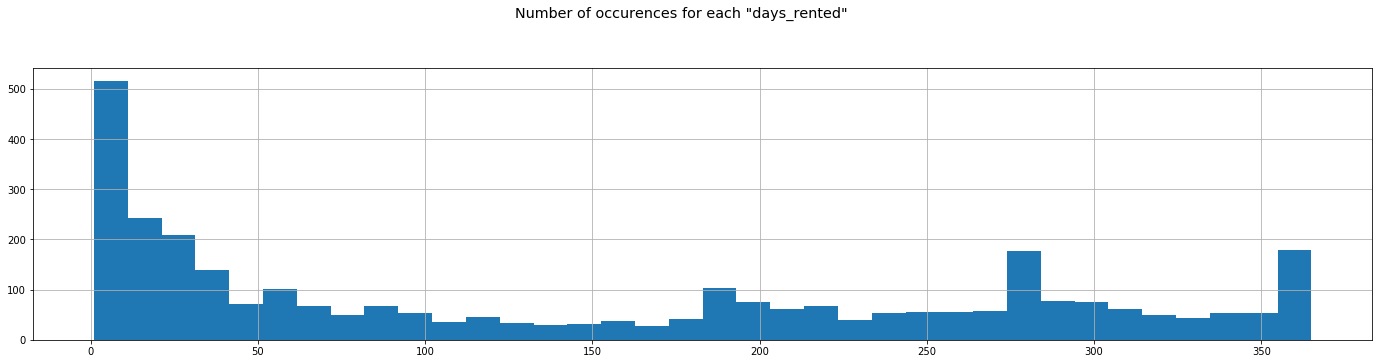

In [29]:
# Part 1 --> Preparing data for Q1, Q3
# Summarise (calendar_relevant_clean - summarised to show - for a given property, how many days it has been rented out) --> output is new dataset called (days_rented_per_property)
# Determine for a given 'listing_id', the number of days it has been rented out (regardless of when)
days_rented_per_property = pd.DataFrame(calendar_relevant_clean.groupby('listing_id')['date'].count().sort_values(ascending=False))
days_rented_per_property.reset_index(level=0, inplace=True)
days_rented_per_property.columns = ['listing_id', 'days_rented']

# Create a historgram to show the number of occurences for each "days_rented"
days_rented_per_property['days_rented'].hist(
                                             bins = 36
                                            ,figsize=(24,5)
                                            );
plt.suptitle('Number of occurences for each "days_rented"', x=0.5, y=1.05, ha='center', fontsize='x-large');

In [30]:
# Create (all_listings_to_days_rented): Left join/merge (listings_relevant_clean) as base, with (days_rented_per_property) on (listing_id)
all_listings_to_days_rented = pd.merge(listings_relevant_clean, days_rented_per_property, how='left', on=['listing_id'])

# Quick check of new data set
print(all_listings_to_days_rented.describe())
# There are property listings with no corresponding calendar data. This means that these properties have not been rented out in the time frame we are analysing.

print(' '*150)
print('-'*150)
print(' '*150)

# Replace all null 'days_rented' with 0
explore_clean_fillna(all_listings_to_days_rented, 'days_rented', 'listing_id', 0)


         listing_id  accommodates     ...       price_clean  days_rented
count  3.810000e+03   3810.000000     ...       3810.000000  3134.000000
mean   5.554043e+06      3.347507     ...        127.917060   146.033504
std    2.960579e+06      1.973033     ...         90.212819   125.405130
min    4.291000e+03      1.000000     ...         20.000000     1.000000
25%    3.263234e+06      2.000000     ...         75.000000    23.000000
50%    6.119072e+06      3.000000     ...        100.000000   118.000000
75%    8.035127e+06      4.000000     ...        150.000000   272.000000
max    1.034016e+07     16.000000     ...       1000.000000   365.000000

[8 rows x 7 columns]
                                                                                                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
                   

In [31]:
# Create a new 'revenue_per_property' field ('price_clean' * 'days_rented')
all_listings_to_days_rented['revenue_per_property'] = all_listings_to_days_rented['price_clean'] * all_listings_to_days_rented['days_rented']

# Quick look
all_listings_to_days_rented.head()

,listing_id,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price_clean,days_rented,revenue_per_property
0,241032,West Queen Anne,Queen Anne,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,19.0,1615.0
1,953595,West Queen Anne,Queen Anne,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,74.0,11100.0
2,3308979,West Queen Anne,Queen Anne,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975.0,145.0,141375.0
3,7421966,West Queen Anne,Queen Anne,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,100.0,222.0,22200.0
4,278830,West Queen Anne,Queen Anne,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,450.0,0.0,0.0


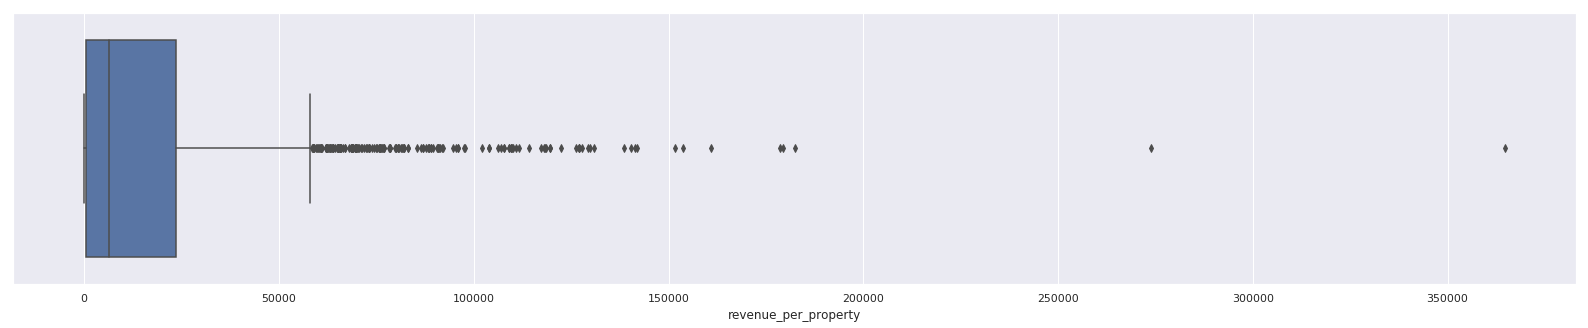

In [32]:
# Quick look at revenue per property distribution using a boxplot

figdim = (28,5)
sns.set(rc={'figure.figsize':figdim})
sns.boxplot(y=all_listings_to_days_rented["revenue_per_property"] , orient='h');

In [33]:
# Part 2 --> Preparing data for Q2
# - Get a subset of (listings_relevant_clean) - showing for a given property, the daily rate --> output is new dataset called (daily_price_per_property)
# Determine for a given 'listing_id', the 'price_clean'
daily_price_per_property = listings_relevant_clean[['listing_id', 'price_clean']]

# - Create (all_days_to_listings_rented): Left join/merge (calendar_relevant_clean) as base with (daily_price_per_property) on ('listing_id')
# -- Ie. For a given date, return all properties that have been rented out
all_days_to_listings_rented_raw = pd.merge(calendar_relevant_clean, daily_price_per_property, how='left', on=['listing_id'])

# - Create a new 'total_revenue_per_day' field = sum('price_clean') groupby ('date','available','year','month','monthname','dayofweek','dayofweekname')
all_days_to_listings_rented = pd.DataFrame(
    all_days_to_listings_rented_raw.groupby(['date','available','year','month','monthname','dayofmonth','dayofweekname'])['price_clean']
        .agg(['sum', 'count']))
all_days_to_listings_rented.reset_index(inplace=True)
all_days_to_listings_rented.columns = ['date','available','year','month','monthname','dayofmonth','dayofweekname', 'total_revenue_per_date', 'total_properties_rented_per_date']

# Quick look
all_days_to_listings_rented.tail()

,date,available,year,month,monthname,dayofmonth,dayofweekname,total_revenue_per_date,total_properties_rented_per_date
360,2016-12-29,f,2016,12,December,29,Thursday,122870.0,980
361,2016-12-30,f,2016,12,December,30,Friday,121961.0,975
362,2016-12-31,f,2016,12,December,31,Saturday,118435.0,956
363,2017-01-01,f,2017,1,January,1,Sunday,108656.0,894
364,2017-01-02,f,2017,1,January,2,Monday,130569.0,1040


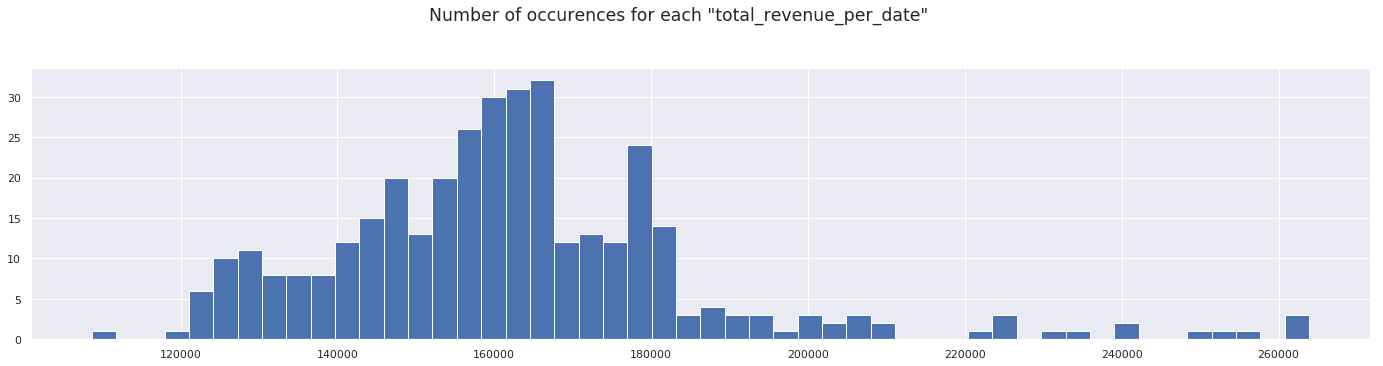

In [34]:
# Create a histogram to show the number of occurences of 'total_revenue_per_date' for each "days_rented"
all_days_to_listings_rented['total_revenue_per_date'].hist(
                                             bins = 50
                                            ,figsize=(24,5)
                                            );
plt.suptitle('Number of occurences for each "total_revenue_per_date"', x=0.5, y=1.05, ha='center', fontsize='x-large');

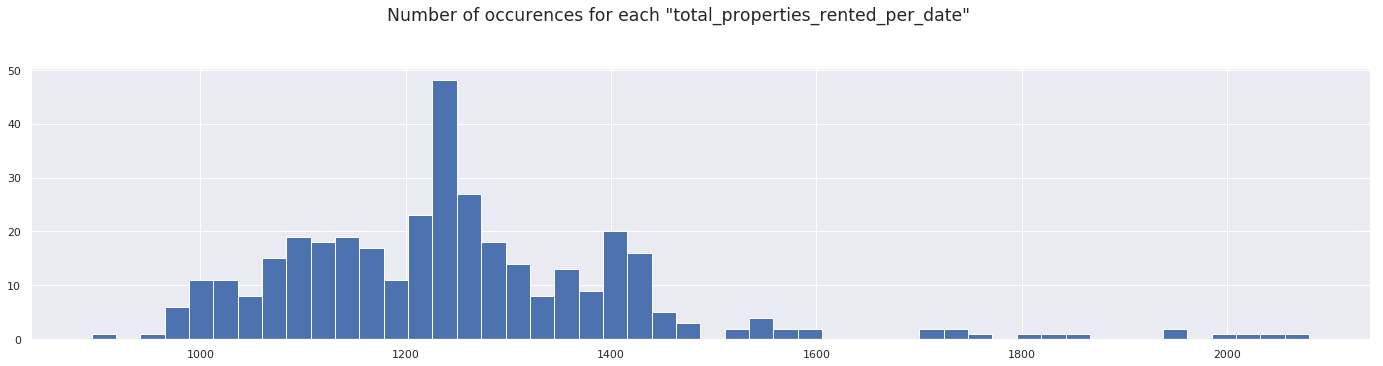

In [35]:
# Create a histogram to show the number of occurences of 'total_properties_rented_per_date' for each "days_rented"
all_days_to_listings_rented['total_properties_rented_per_date'].hist(
                                             bins = 50
                                            ,figsize=(24,5)
                                            );
plt.suptitle('Number of occurences for each "total_properties_rented_per_date"', x=0.5, y=1.05, ha='center', fontsize='x-large');

## **Modelling, Evaluation, Deployment**

From this point onwards, we will be changing the approach slightly.
We will be performing the Modelling, Evaluation and Deployment steps end to end for each of the following 3 business questions.

> **1. What are the highest revenue generating locations for Seattle hosts?**
 * We are keen to find out the best neighbourhood to buy the property. 
 
> **2. When in the year are the highest revenues generated? **
 * Knowing the time of the year that drives the most revenue will enable us to vary prices to maximise revenue at those times.

> **3. What are the property types that attract the highest revenues? ** 
 * It is beneficial to pruchase a property that is in high demand.
 
Let's get started!!!


## **Question 1: What are the highest revenue generating locations for Seattle hosts?**

We are keen to find out the best location (at the neighbourhood level) to buy the property. The cells after this contain the workings for the steps below.

### **Modelling**
 - We are using the (all_listings_to_days_rented) dataset prepared earlier.
 - The dataset is then summarised to provide the average revenue per property, number of properties, and total revenue of all properties for each neighbourhood. 
 - The summarised data is then presented in a table, where each row covers a neighbourhood. The records are sorted by average revenue per property in each neighbourhood in descending order. In each of the summarised columns, the maximum values are highlighted in 'Gold' and the values are shaded in different gradients of 'Green' (the darker the gradient, the higher the value is within the column).  
 
### **Evaluation**
 - It is best to look at the data from multiple angles. Here, we look at the average revenue per property, total revenue and number of properties in each neighbourhood.
 - From the perspective of average revenue per property, Montlake ranks the highest where a property here makes $ 37,740 on average. 

 - From the viewpoint of total revenue, Broadway ranks the highest where all properties collectively generated $ 6,475,088 in revenue. Broadway also has the highest number of properties at 396. 

 - Properties in this neighbourhood makes $ 16,351 dollars on average, which is less than 50 percent of what a property in Montlake makes. Given that there are a large number of properties, there is greater competition, resulting in more competitive pricing.
 
 - This is an interesting insight. We need to consider all these information hollistically. 
 
 - We recommend buyers to focus on properties in neighbourhoods with high average revenue per property (Montlake, South Lake Union, North Beach/Blue Ridge) to get the greatest return on investment. It should be noted that these neighbourhoods have relatively small number of properties (19,27,14 respectively) which indicate a slightly more rural locality, where there may be challenges finding demand for properties here. 
 - Therefore, a further recommendation would be for buyers to target properties in neighbourhoods which ranks well in terms of average revenue per property, total revenue and number of properties. Neighbourhoods that fit this bill are Belltown, East Queen Anne and West Queen Anne. Buying properties here could have a better flow of demand, given its more central locality. 

 
### **Deployment**
 - There is no model deployment here.
 

In [36]:
# Quick look at which level of neighbourhood to continue analysis on

all_listings_to_days_rented[['neighbourhood_group_cleansed', 'neighbourhood_cleansed']].nunique()

neighbourhood_group_cleansed    17
neighbourhood_cleansed          87
dtype: int64

In [57]:
# Add in additional revenue metrics
revenue_by_location = pd.DataFrame(all_listings_to_days_rented.groupby(['neighbourhood_cleansed'])['revenue_per_property'].agg(['sum', 'count', 'mean']))
revenue_by_location.reset_index(inplace=True)
revenue_by_location.columns = ['neighbourhood_cleansed','total_revenue','number_of_properties','average_revenue_per_property']
revenue_by_location = revenue_by_location.sort_values(by='average_revenue_per_property', ascending=False)

# Apply color based conditional formatting on the data frame
cm = sns.light_palette("seagreen", as_cmap=True)

(revenue_by_location.style
  .background_gradient(cmap=cm, subset=['total_revenue','number_of_properties','average_revenue_per_property'])
  .highlight_max(subset=['total_revenue','number_of_properties','average_revenue_per_property'], color='gold')

  .format({'total_revenue': "${:,.0f}"})
  .format({'average_revenue_per_property': "${:,.2f}"}) 
)

# Look at average revenue per property, then total revenue

,neighbourhood_cleansed,total_revenue,number_of_properties,average_revenue_per_property
48,Montlake,"$717,061",19,"$37,740.05"
71,South Lake Union,"$689,034",27,"$25,519.78"
51,North Beach/Blue Ridge,"$355,343",14,"$25,381.64"
41,Madrona,"$1,079,144",47,"$22,960.51"
61,Portage Bay,"$296,823",13,"$22,832.54"
4,Belltown,"$5,294,610",234,"$22,626.54"
23,Genesee,"$721,497",34,"$21,220.50"
16,East Queen Anne,"$1,736,843",82,"$21,181.01"
78,View Ridge,"$147,645",7,"$21,092.14"
81,West Queen Anne,"$1,357,459",65,"$20,883.98"


## **Question 2: When in the year are the highest revenues generated?**

This involves knowing the time of the year that generates the most revenue. Having this insight will enable us to vary prices and ensure our properties are available for rent at those times to maximise revenue. The cells after this contain the workings for the steps below.

### **Modelling**
 - We are using the (all_days_to_listings_rented) dataset prepared earlier.
 - The dataset is then summarised at 3 levels (month level, phase of month level, day of week level) to provide the average revenue per property, number of properties, and total revenue of all properties. 
 - For all 3 levels, the summarised data is presented in a table, where each row covers a level. The records are sorted by average revenue per property in each neighbourhood in descending order. In each of the summarised columns, the maximum values are highlighted in 'Gold' and the values are shaded in different gradients of 'Green' (the darker the gradient, the higher the value is within the column).  
 - Charts are also created to help visualise and identify trends at all 3 levels.
 
### **Evaluation**
 - As for Question 1, it is best to look at the data from multiple angles. Here, we look at the average revenue per property, total revenue and number of properties in each time level.
 - Firstly, at a 'month' level:
 > - The highest average revenue generated per property is achieved in March, followed by February. In general, a relatively high average revenue is achieved in the Quarter 1 of the calendar year (January to March).
 > - January recorded the highest number of properties rented and generated the highest revenue in the year. 
 > - Hence, it is recommended that property owners put their place up for rent in the first quarter of the year (January to March).
 - Secondly, at the 'phase of month' level:
 > - The average revenue generated increases in the last 2 phases of the month and peaks in the last phase of the month (from the 24th to 31st days). 
 > - However, it is interesting to note that the highest amounts of total revenue is generated in phases 2 and 3 of the month (from the 16th to the 23rd days). 
 > - Given this conflicting trends, we would recommend property owners to put their places up for rent at the end of the month if they are after higher yield over a short time frame. Alternatively, if property owners are content with renting their places out over longer periods at lower yields, they should make their properties available in the middle of the month. 
 - Thirdly, at the 'day of week' level:
 > - Thursday generates the highest average revenue per property, followed by Friday, Wednesday and Saturday.
 > - On the other hand, Monday generates the highest total revenue (and also has the highest number of properties rented). This is followed by Saturday, Friday, Thursday and Wednesday.
 > - We recommend property owners to put their place up for rent between Wednesday to Saturday as there is good demand for places and also evidence that renters are willing to pay a slight premium for places. 

 - Overall, we recommend buyers and property owners to make their properties available for rent in the 1st quarter of the calendar year (January to March), focusing on periods towards the end of the month, especially between Wednesdays to Saturdays.
 
### **Deployment**
 - There is no model deployment here.
 

In [38]:
print(list(all_days_to_listings_rented.columns))
all_days_to_listings_rented.head()

['date', 'available', 'year', 'month', 'monthname', 'dayofmonth', 'dayofweekname', 'total_revenue_per_date', 'total_properties_rented_per_date']


,date,available,year,month,monthname,dayofmonth,dayofweekname,total_revenue_per_date,total_properties_rented_per_date
0,2016-01-04,f,2016,1,January,4,Monday,263885.0,2080
1,2016-01-05,f,2016,1,January,5,Tuesday,249636.0,1947
2,2016-01-06,f,2016,1,January,6,Wednesday,254924.0,1987
3,2016-01-07,f,2016,1,January,7,Thursday,262913.0,2037
4,2016-01-08,f,2016,1,January,8,Friday,262028.0,2031


In [39]:
# Quick look at which level of dates to continue analysis on

all_days_to_listings_rented[['date', 'year', 'month', 'monthname', 'dayofmonth','dayofweekname']].nunique()

# From the output below, it makes sense to look for trends at 3 levels: 
# -- month
# -- phase of month --> day of month (which will be further summarised into phase of month --> p1, p2, p3, p4 at 8 days intervals)
# -- day of week

# Separate offshoot data sets will be created with revenue metrics summarised at each of the 3 levels.

date             365
year               2
month             12
monthname         12
dayofmonth        31
dayofweekname      7
dtype: int64

In [40]:
# Analysis at the 'month' level

# Create a new data set for 'month' level analysis
all_days_to_listings_rented_month_lvl = all_days_to_listings_rented

# Create a unified 'monthofyear' column
all_days_to_listings_rented_month_lvl['month']= all_days_to_listings_rented_month_lvl['month'].apply('{:0>2}'.format)
all_days_to_listings_rented_month_lvl['monthofyear'] = all_days_to_listings_rented_month_lvl['month'] + ' - ' + all_days_to_listings_rented_month_lvl['monthname']

# Calculate total revenue generated per month
all_days_to_listings_rented_month_lvl_revenue = pd.DataFrame(all_days_to_listings_rented_month_lvl.groupby(['monthofyear'])['total_revenue_per_date'].agg(['sum']))
all_days_to_listings_rented_month_lvl_revenue.reset_index(inplace=True)
all_days_to_listings_rented_month_lvl_revenue.columns = ['monthofyear','total_revenue']

# Calculate total number of properties rented per month
all_days_to_listings_rented_month_lvl_propcount = pd.DataFrame(all_days_to_listings_rented_month_lvl.groupby(['monthofyear'])['total_properties_rented_per_date'].agg(['sum']))
all_days_to_listings_rented_month_lvl_propcount.reset_index(inplace=True)
all_days_to_listings_rented_month_lvl_propcount.columns = ['monthofyear','total_property_rented']

# Merge both component tables, and calculate average revenue generated per property for each month
all_days_to_listings_rented_month_lvl_combined = pd.merge(all_days_to_listings_rented_month_lvl_revenue, all_days_to_listings_rented_month_lvl_propcount, how='left', on=['monthofyear'])
all_days_to_listings_rented_month_lvl_combined['average_revenue_per_property'] = all_days_to_listings_rented_month_lvl_combined['total_revenue']/all_days_to_listings_rented_month_lvl_combined['total_property_rented']
all_days_to_listings_rented_month_lvl_combined

,monthofyear,total_revenue,total_property_rented,average_revenue_per_property
0,01 - January,6461686.0,49497,130.547023
1,02 - February,4998413.0,37281,134.074006
2,03 - March,4705585.0,34333,137.057204
3,04 - April,5009859.0,38410,130.431112
4,05 - May,4997312.0,38283,130.536060
5,06 - June,4878545.0,37192,131.171892
6,07 - July,5597605.0,44012,127.183609
7,08 - August,5318770.0,41873,127.021470
8,09 - September,4696980.0,37174,126.351213
9,10 - October,4516223.0,35796,126.165577


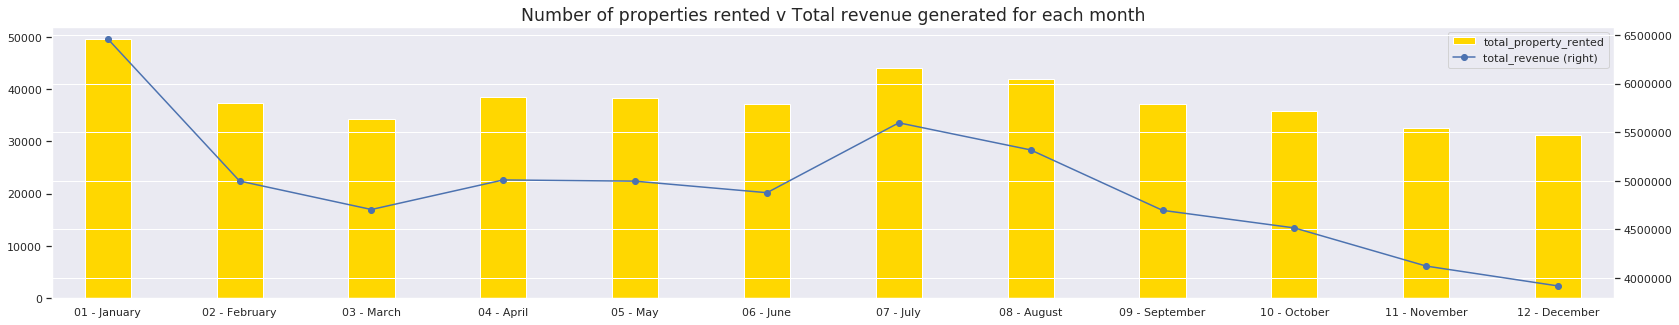

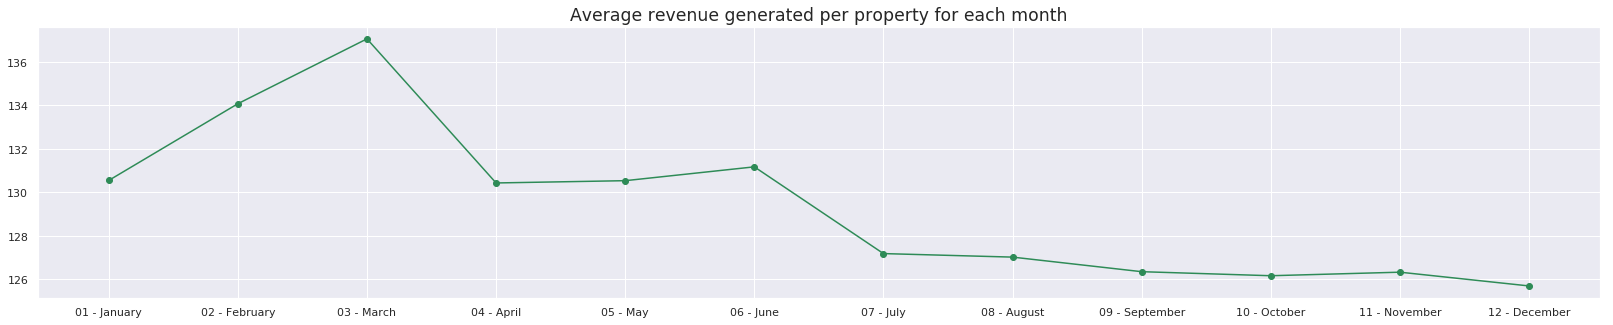

,monthofyear,total_revenue,total_property_rented,average_revenue_per_property
0,01 - January,"$6,461,686",49497,$130.55
1,02 - February,"$4,998,413",37281,$134.07
2,03 - March,"$4,705,585",34333,$137.06
3,04 - April,"$5,009,859",38410,$130.43
4,05 - May,"$4,997,312",38283,$130.54
5,06 - June,"$4,878,545",37192,$131.17
6,07 - July,"$5,597,605",44012,$127.18
7,08 - August,"$5,318,770",41873,$127.02
8,09 - September,"$4,696,980",37174,$126.35
9,10 - October,"$4,516,223",35796,$126.17


In [41]:
# Plot the 'month' level summarised data for insights

x_input = all_days_to_listings_rented_month_lvl_combined['monthofyear']
y1_input = all_days_to_listings_rented_month_lvl_combined['total_property_rented']
y2_input = all_days_to_listings_rented_month_lvl_combined['total_revenue']
y3_input = all_days_to_listings_rented_month_lvl_combined['average_revenue_per_property']


# ax1
fig1, ax1 = plt.subplots()
width = 0.35

ax1 = y1_input.plot(kind='bar', width = width, color='Gold', legend=True)
ax1 = y2_input.plot(kind='line', marker='o', secondary_y=True, legend=True)
ax1.set_title('Number of properties rented v Total revenue generated for each month'
              , fontdict={'fontsize': 'x-large'})
ax1 = plt.gca()
ax1.set_xticks(np.arange(len(x_input)))
ax1.set_xticklabels(x_input)


# ax2
fig2, ax2 = plt.subplots()
ax2 = y3_input.plot(kind='line', marker = 'o', color='seagreen')
ax2.set_title('Average revenue generated per property for each month'
              , fontdict={'fontsize': 'x-large'})
ax2 = plt.gca()
ax2.set_xticks(np.arange(len(x_input)))
ax2.set_xticklabels(x_input)


# Display plots
plt.show();


# ------------------------------------------------------------------------------------------------------------------------------

# Apply color based conditional formatting on the data frame
cm = sns.light_palette("seagreen", as_cmap=True)

(all_days_to_listings_rented_month_lvl_combined.style
  .background_gradient(cmap=cm, subset=['total_revenue','total_property_rented', 'average_revenue_per_property'])
  .highlight_max(subset=['total_revenue','total_property_rented', 'average_revenue_per_property'], color='gold')

  .format({'total_revenue': "${:,.0f}"})
  .format({'average_revenue_per_property': "${:,.2f}"})  
)

# Look at average revenue per property, then total revenue

In [42]:
# Analysis at the 'phase of month' level

# We will categorise the days of month (1 to 31) into 4 buckets:
# -- p1_of_month: Days 1 to 7
# -- p2_of_month: Days 8 to 15
# -- p3_of_month: Days 16 to 23
# -- p4_of_month: Days 24 to 31

# Create a new data set for 'phase of month' level analysis
all_days_to_listings_rented_phaseofmonth_lvl = all_days_to_listings_rented

# Create a 'phaseofmonth' column
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofmonth'] >= 1), 'phaseofmonth'] = '1 - p1 of month'
all_days_to_listings_rented_phaseofmonth_lvl.loc[all_days_to_listings_rented_phaseofmonth_lvl['dayofmonth'] >= 8, 'phaseofmonth'] = '2 - p2 of month'
all_days_to_listings_rented_phaseofmonth_lvl.loc[all_days_to_listings_rented_phaseofmonth_lvl['dayofmonth'] >= 16, 'phaseofmonth'] = '3 - p3 of month'
all_days_to_listings_rented_phaseofmonth_lvl.loc[all_days_to_listings_rented_phaseofmonth_lvl['dayofmonth'] >= 24, 'phaseofmonth'] = '4 - p4 of month'

# all_days_to_listings_rented_phaseofmonth_lvl['phaseofmonth'] = all_days_to_listings_rented_phaseofmonth_lvl['dayofmonth']

# # Calculate total revenue generated per 'phaseofmonth'
all_days_to_listings_rented_phaseofmonth_lvl_revenue = pd.DataFrame(all_days_to_listings_rented_phaseofmonth_lvl.groupby(['phaseofmonth'])['total_revenue_per_date'].agg(['sum']))
all_days_to_listings_rented_phaseofmonth_lvl_revenue.reset_index(inplace=True)
all_days_to_listings_rented_phaseofmonth_lvl_revenue.columns = ['phaseofmonth','total_revenue']

# # Calculate total number of properties rented per 'phaseofmonth'
all_days_to_listings_rented_phaseofmonth_lvl_propcount = pd.DataFrame(all_days_to_listings_rented_phaseofmonth_lvl.groupby(['phaseofmonth'])['total_properties_rented_per_date'].agg(['sum']))
all_days_to_listings_rented_phaseofmonth_lvl_propcount.reset_index(inplace=True)
all_days_to_listings_rented_phaseofmonth_lvl_propcount.columns = ['phaseofmonth','total_property_rented']

# # Merge both component tables, and calculate average revenue generated per property for each month phase
all_days_to_listings_rented_phaseofmonth_lvl_combined = pd.merge(all_days_to_listings_rented_phaseofmonth_lvl_revenue, all_days_to_listings_rented_phaseofmonth_lvl_propcount, how='left', on=['phaseofmonth'])
all_days_to_listings_rented_phaseofmonth_lvl_combined['average_revenue_per_property'] = all_days_to_listings_rented_phaseofmonth_lvl_combined['total_revenue']/all_days_to_listings_rented_phaseofmonth_lvl_combined['total_property_rented']
all_days_to_listings_rented_phaseofmonth_lvl_combined

,phaseofmonth,total_revenue,total_property_rented,average_revenue_per_property
0,1 - p1 of month,13735398.0,106178,129.361996
1,2 - p2 of month,15894930.0,122929,129.301711
2,3 - p3 of month,15404838.0,119023,129.427405
3,4 - p4 of month,14188113.0,109539,129.525676


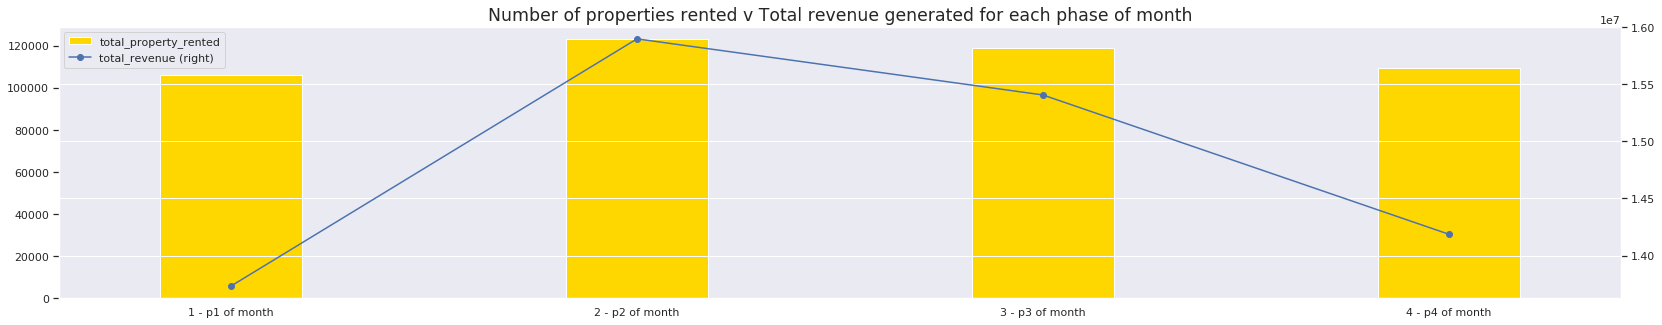

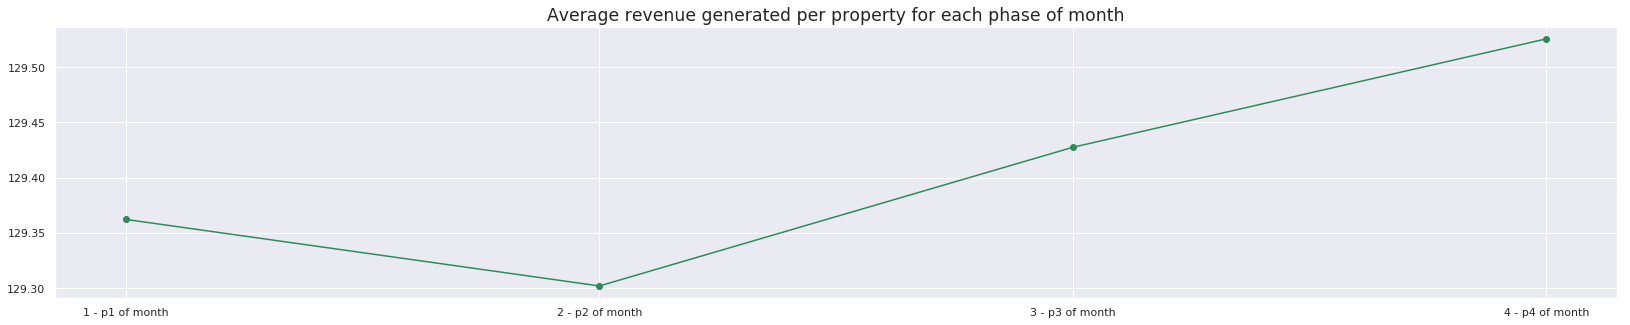

,phaseofmonth,total_revenue,total_property_rented,average_revenue_per_property
0,1 - p1 of month,"$13,735,398",106178,$129.36
1,2 - p2 of month,"$15,894,930",122929,$129.30
2,3 - p3 of month,"$15,404,838",119023,$129.43
3,4 - p4 of month,"$14,188,113",109539,$129.53


In [43]:
# Plot the 'phase of month' level summarised data for insights

x_input = all_days_to_listings_rented_phaseofmonth_lvl_combined['phaseofmonth']
y1_input = all_days_to_listings_rented_phaseofmonth_lvl_combined['total_property_rented']
y2_input = all_days_to_listings_rented_phaseofmonth_lvl_combined['total_revenue']
y3_input = all_days_to_listings_rented_phaseofmonth_lvl_combined['average_revenue_per_property']


# ax1
fig1, ax1 = plt.subplots()
width = 0.35

ax1 = y1_input.plot(kind='bar', width = width, color='Gold', legend=True)
ax1 = y2_input.plot(kind='line', marker='o', secondary_y=True, legend=True)
ax1.set_title('Number of properties rented v Total revenue generated for each phase of month'
              , fontdict={'fontsize': 'x-large'})
ax1 = plt.gca()
ax1.set_xticks(np.arange(len(x_input)))
ax1.set_xticklabels(x_input)


# ax2
fig2, ax2 = plt.subplots()
ax2 = y3_input.plot(kind='line', marker = 'o', color='seagreen')
ax2.set_title('Average revenue generated per property for each phase of month'
              , fontdict={'fontsize': 'x-large'})
ax2 = plt.gca()
ax2.set_xticks(np.arange(len(x_input)))
ax2.set_xticklabels(x_input)


# Display plots
plt.show();


# ------------------------------------------------------------------------------------------------------------------------------

# Apply color based conditional formatting on the data frame
cm = sns.light_palette("seagreen", as_cmap=True)

(all_days_to_listings_rented_phaseofmonth_lvl_combined.style
  .background_gradient(cmap=cm, subset=['total_revenue','total_property_rented', 'average_revenue_per_property'])
  .highlight_max(subset=['total_revenue','total_property_rented', 'average_revenue_per_property'], color='gold')

  .format({'total_revenue': "${:,.0f}"})
  .format({'average_revenue_per_property': "${:,.2f}"})  
)

# Look at average revenue per property, then total revenue

In [44]:
# Analysis at the 'day of week' level

# Create a new data set for 'dayofweek' level analysis
all_days_to_listings_rented_dayofweek_lvl = all_days_to_listings_rented

# Create a 'dayofweek' column
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Monday'), 'dayofweek'] = '1 - Monday'
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Tuesday'), 'dayofweek'] = '2 - Tuesday'
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Wednesday'), 'dayofweek'] = '3 - Wednesday'
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Thursday'), 'dayofweek'] = '4 - Thursday'
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Friday'), 'dayofweek'] = '5 - Friday'
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Saturday'), 'dayofweek'] = '6 - Saturday'
all_days_to_listings_rented_phaseofmonth_lvl.loc[(all_days_to_listings_rented_phaseofmonth_lvl['dayofweekname'] == 'Sunday'), 'dayofweek'] = '7 - Sunday'

# # Calculate total revenue generated per 'dayofweek'
all_days_to_listings_rented_dayofweek_lvl_revenue = pd.DataFrame(all_days_to_listings_rented_dayofweek_lvl.groupby(['dayofweek'])['total_revenue_per_date'].agg(['sum']))
all_days_to_listings_rented_dayofweek_lvl_revenue.reset_index(inplace=True)
all_days_to_listings_rented_dayofweek_lvl_revenue.columns = ['dayofweek','total_revenue']

# # Calculate total number of properties rented per 'dayofweek'
all_days_to_listings_rented_dayofweek_lvl_propcount = pd.DataFrame(all_days_to_listings_rented_dayofweek_lvl.groupby(['dayofweek'])['total_properties_rented_per_date'].agg(['sum']))
all_days_to_listings_rented_dayofweek_lvl_propcount.reset_index(inplace=True)
all_days_to_listings_rented_dayofweek_lvl_propcount.columns = ['dayofweek','total_property_rented']

# # Merge both component tables, and calculate average revenue generated per property for each day of week
all_days_to_listings_rented_dayofweek_lvl_combined = pd.merge(all_days_to_listings_rented_dayofweek_lvl_revenue, all_days_to_listings_rented_dayofweek_lvl_propcount, how='left', on=['dayofweek'])
all_days_to_listings_rented_dayofweek_lvl_combined['average_revenue_per_property'] = all_days_to_listings_rented_dayofweek_lvl_combined['total_revenue']/all_days_to_listings_rented_dayofweek_lvl_combined['total_property_rented']
all_days_to_listings_rented_dayofweek_lvl_combined

,dayofweek,total_revenue,total_property_rented,average_revenue_per_property
0,1 - Monday,8570378.0,66361,129.147813
1,2 - Tuesday,8393920.0,64940,129.256545
2,3 - Wednesday,8410047.0,64971,129.443090
3,4 - Thursday,8481433.0,65375,129.735113
4,5 - Friday,8495343.0,65534,129.632603
5,6 - Saturday,8510246.0,65762,129.409781
6,7 - Sunday,8361912.0,64726,129.189383


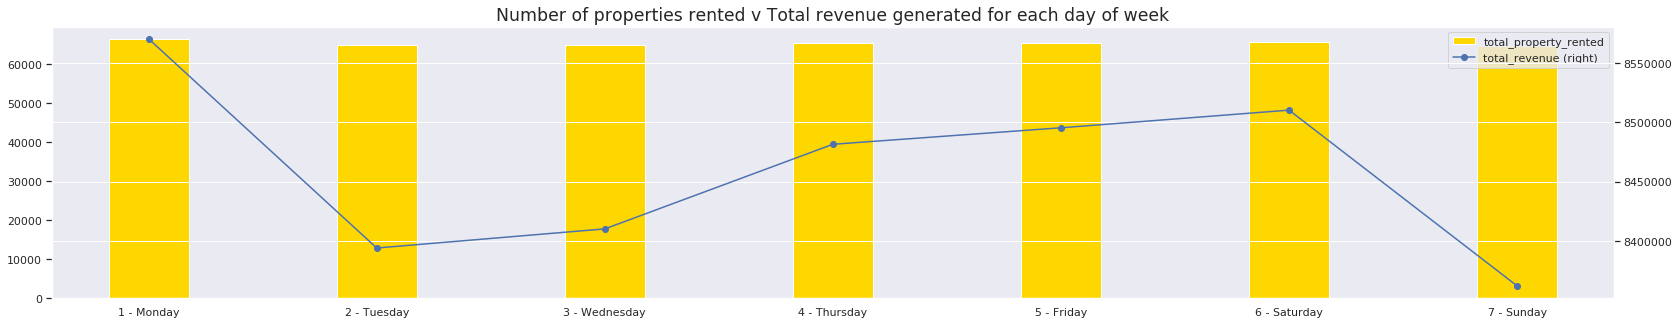

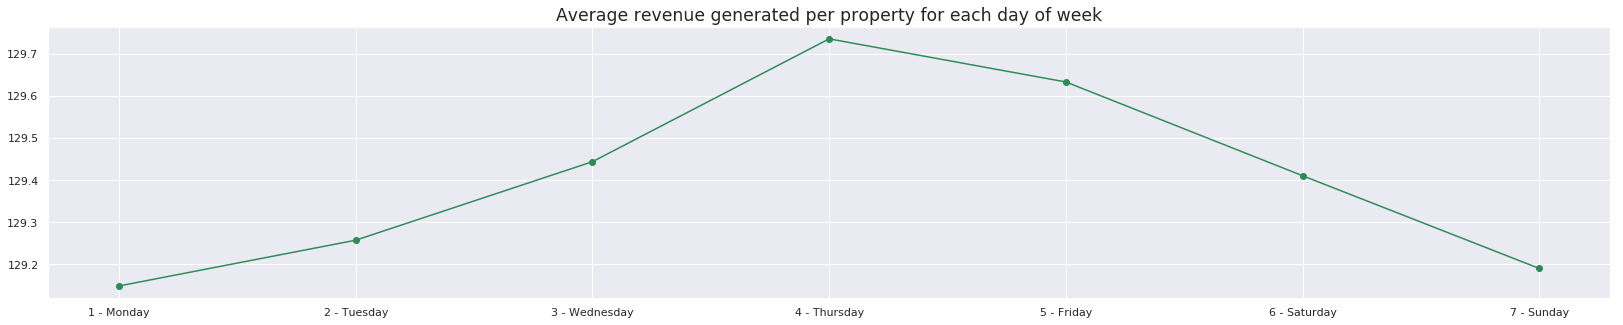

,dayofweek,total_revenue,total_property_rented,average_revenue_per_property
0,1 - Monday,"$8,570,378",66361,$129.15
1,2 - Tuesday,"$8,393,920",64940,$129.26
2,3 - Wednesday,"$8,410,047",64971,$129.44
3,4 - Thursday,"$8,481,433",65375,$129.74
4,5 - Friday,"$8,495,343",65534,$129.63
5,6 - Saturday,"$8,510,246",65762,$129.41
6,7 - Sunday,"$8,361,912",64726,$129.19


In [45]:
# Plot the 'day of week' level summarised data for insights

x_input = all_days_to_listings_rented_dayofweek_lvl_combined['dayofweek']
y1_input = all_days_to_listings_rented_dayofweek_lvl_combined['total_property_rented']
y2_input = all_days_to_listings_rented_dayofweek_lvl_combined['total_revenue']
y3_input = all_days_to_listings_rented_dayofweek_lvl_combined['average_revenue_per_property']


# ax1
fig1, ax1 = plt.subplots()
width = 0.35

ax1 = y1_input.plot(kind='bar', width = width, color='Gold', legend=True)
ax1 = y2_input.plot(kind='line', marker='o', secondary_y=True, legend=True)
ax1.set_title('Number of properties rented v Total revenue generated for each day of week'
              , fontdict={'fontsize': 'x-large'})
ax1 = plt.gca()
ax1.set_xticks(np.arange(len(x_input)))
ax1.set_xticklabels(x_input)


# ax2
fig2, ax2 = plt.subplots()
ax2 = y3_input.plot(kind='line', marker = 'o', color='seagreen')
ax2.set_title('Average revenue generated per property for each day of week'
              , fontdict={'fontsize': 'x-large'})
ax2 = plt.gca()
ax2.set_xticks(np.arange(len(x_input)))
ax2.set_xticklabels(x_input)


# Display plots
plt.show();


# ------------------------------------------------------------------------------------------------------------------------------

# Apply color based conditional formatting on the data frame
cm = sns.light_palette("seagreen", as_cmap=True)

(all_days_to_listings_rented_dayofweek_lvl_combined.style
  .background_gradient(cmap=cm, subset=['total_revenue','total_property_rented', 'average_revenue_per_property'])
  .highlight_max(subset=['total_revenue','total_property_rented', 'average_revenue_per_property'], color='gold')

  .format({'total_revenue': "${:,.0f}"})
  .format({'average_revenue_per_property': "${:,.2f}"})  
)

# Look at average revenue per property, then total revenue

## **Question 3: Can we predict the property characteristics that attract the highest revenues?**

This involves predicting the traits of property that will attract high demand and generate the highest revenue. Having this insight will enable us to purchase properties with the specific traits to maximise revenue. The cells after this contain the workings for the steps below.

### **Modelling**
 - We are using the (all_listings_to_days_rented) dataset prepared earlier. 
 - We select all the fields relevant to property traits and store it in a new data frame (all_listings_to_days_rented_proptrait).   
 - We encode the categorical features, and standardize the data values.
 - This is followed by initializing and running the prediction models and finally scoring the models, to determine if the assortment of features have predictive powers.
 - We are using a mix of tree and linear, and the Decision Tree Regressor model performed better than the traditional and enhanced linear models. This indicates that the relationship isn't linear.
 
### **Evaluation**
 - From the Decision Tree Regressor model, we look at the features with the greatest feature importance. These features are:
 > - bedrooms	(0.673662)
 > - room_type_Entire home/apt	(0.214706)
 > - accommodates	(0.054830)
 > - bathrooms	(0.030718)
 > - property_type_House	(0.026084)
 - We also checked the correlations between the 'revenue per property' with all the features. The features with the highest correlations are:
 > - bedrooms                         (0.360102)
 > - accommodates                     (0.331536)
 > - beds                             (0.288501)
 > - room_type_Entire home/apt        (0.280029)
 > - bathrooms                        (0.256875)
 > - room_type_Private room          (-0.250865)
 - Using both pieces of information, we can see an overlap which strengthens our confidence that these features have some form of predictive power that impacts the revenue a property can generate.
 - We recommend that a property owners who are looking to renovate their existing property / buyers of new investment properties who are looking to rent it out via AirBnB, focus on ensuring their properties:
 > - Have more bedrooms, beds and bathrooms, thus enabling the property to accommodate more people as these increase revenue generating potential
 > - That are houses
 > - Which can be rented out in its entirety, instead of a property where only a single private room can be rented out
 
### **Deployment**
 - There is no model deployment here. There will be further improvements to the predictive models in the future.
 

In [46]:
# Limit the data set to only relevant fields
all_listings_to_days_rented_proptrait = all_listings_to_days_rented[[
                                                                     'property_type',
                                                                     'room_type',
                                                                     'accommodates',
                                                                     'bathrooms',
                                                                     'bedrooms',
                                                                     'beds',
                                                                     'bed_type',
                                                                     'revenue_per_property'
                                                                    ]]
all_listings_to_days_rented_proptrait.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,revenue_per_property
0,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,1615.0
1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,11100.0
2,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,141375.0
3,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,22200.0
4,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,0.0


In [47]:
# Check the data type of each field
all_listings_to_days_rented_proptrait.dtypes

# Identify the non-numeric fields that will be encoded
encode_cols = ['property_type', 'room_type', 'bed_type']

# Perform 1 hot encoding
all_listings_to_days_rented_proptrait=pd.get_dummies(data=all_listings_to_days_rented_proptrait, columns=encode_cols,drop_first=False)
# all_listings_to_days_rented_proptrait.head()

# Split data into (x)features and (y)target
y_target =  all_listings_to_days_rented_proptrait['revenue_per_property']

x_features = all_listings_to_days_rented_proptrait.drop('revenue_per_property', axis=1)

In [48]:
x_features.head()

,accommodates,bathrooms,bedrooms,beds,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,4,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,4,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,11,4.5,5.0,7.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3,1.0,0.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,6,2.0,3.0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [49]:
# Creating a scaling feature set
x_features_scaled = x_features

# Get column names first
col_names = list(x_features_scaled.columns)

# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object - perform standard scaling on (x)
x_features_scaled = scaler.fit_transform(x_features_scaled)
x_features_scaled = pd.DataFrame(x_features_scaled, columns=col_names)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [50]:
#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_features_scaled, 
                                                    y_target, 
                                                    test_size=0.20, 
                                                    random_state=71)

In [51]:
# Create a function to establish a training and testing pipeline 
# (drawn from Term 1: https://github.com/MikeBong/udacity_datascience_nd/blob/master/project_finding_donors/finding_donors-MikeBong-02.ipynb).
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #Compute accuracy on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
    
    #Compute accuracy on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print('-'*90)
    print("MSE_train: %.4f" % results['mse_train'])
    print("MSE_test: %.4f" % results['mse_test'])
    print("Training score:%.4f" % learner.score(X_train,y_train))
    print("Test score:%.4f" % learner.score(X_test,y_test))
    print(' '*90)
    print('+'*90)

    return results

In [52]:
#Initialize the models
clf1 = LinearRegression()
clf2 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=10,min_samples_split=10,max_leaf_nodes=8,random_state=71)
clf3 = Lasso()
clf4 = RidgeCV() 

# Calculate the number of samples for 1% and 100% of the training data
samples_100 = len(y_train)
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf1, clf2, clf3, clf4]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LinearRegression trained on 30 samples.
------------------------------------------------------------------------------------------
MSE_train: 623993488.6720
MSE_test: 620408446.8634
Training score:-0.3022
Test score:-0.2978
                                                                                          
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LinearRegression trained on 3048 samples.
------------------------------------------------------------------------------------------
MSE_train: 436917849.5623
MSE_test: 370401264.1938
Training score:0.1654
Test score:0.2252
                                                                                          
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DecisionTreeRegressor trained on 30 samples.
------------------------------------------------------------------------------------------
MSE_train: 611658829.0111
MSE_test: 641585509.0171
T

In [53]:
# From the scores generated, both models are quite poor.
# The decision tree regressor performed better than the linear regression model.

# We now extract the feature importance from the relatively better decision tree regressor model
feature_importances = pd.DataFrame(clf2.feature_importances_,
                                   index = X_train.columns,
                                    columns=['coefficient']).sort_values('coefficient', ascending=False)

# The features ranked in order of importance per the decision tree regressor can be found below.

feature_importances.sort_values(by= 'coefficient', ascending=False)

# Admittedly the models can be improved, though this provides us with a good starting point to provide preliminary recommendations to buyers and owners.

,coefficient
bedrooms,0.673662
room_type_Entire home/apt,0.214706
accommodates,0.054830
bathrooms,0.030718
property_type_House,0.026084
property_type_Other,0.000000
beds,0.000000
property_type_Apartment,0.000000
property_type_Bed & Breakfast,0.000000
property_type_Boat,0.000000


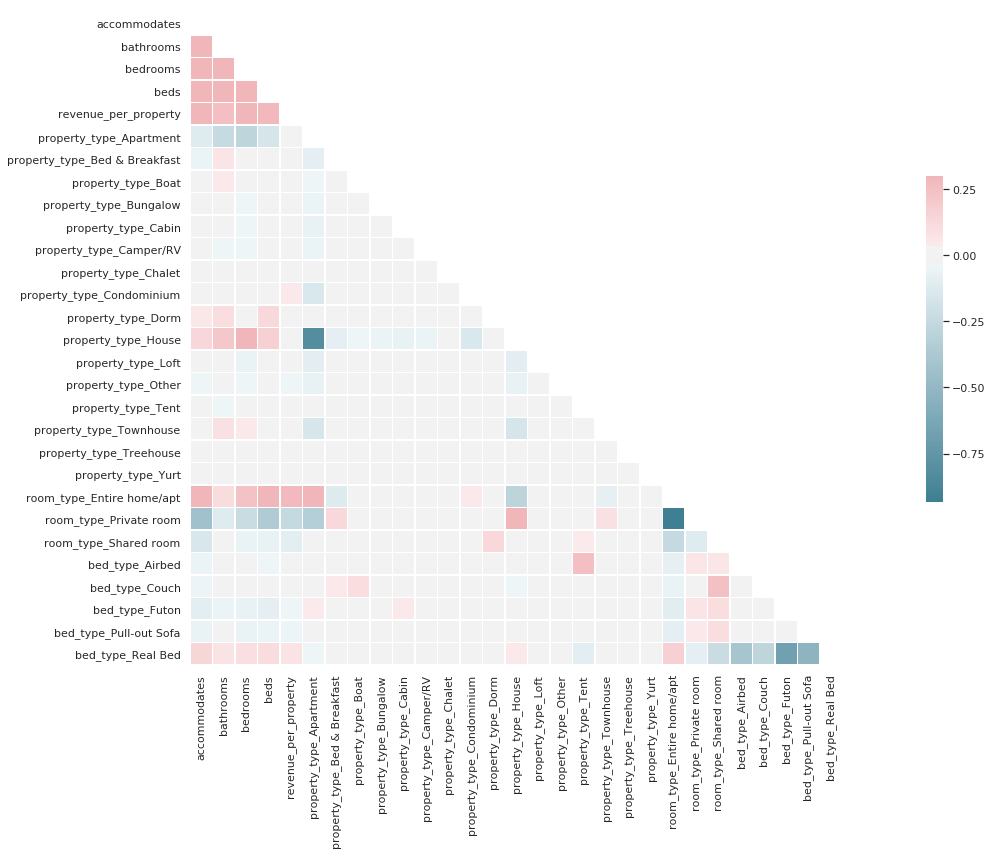

In [54]:
# Plot the correlation between the features and targets in the data set
# We will use this to corroborate the sub par results from the models ran above

sns.set(style="white")

# Nominate dataset
d = all_listings_to_days_rented_proptrait

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [55]:
corr['revenue_per_property'].sort_values(ascending=False) 

revenue_per_property             1.000000
bedrooms                         0.360102
accommodates                     0.331536
beds                             0.288501
room_type_Entire home/apt        0.280029
bathrooms                        0.256875
bed_type_Real Bed                0.069669
property_type_Condominium        0.042702
property_type_House              0.021916
property_type_Townhouse          0.015501
property_type_Loft               0.008943
property_type_Treehouse          0.008549
property_type_Yurt               0.002333
property_type_Tent              -0.009447
property_type_Dorm              -0.009474
property_type_Boat              -0.009678
property_type_Chalet            -0.011377
property_type_Bungalow          -0.012116
property_type_Camper/RV         -0.012611
bed_type_Couch                  -0.014561
property_type_Cabin             -0.014763
property_type_Apartment         -0.023490
bed_type_Airbed                 -0.026726
property_type_Bed & Breakfast   -0

**References**
* Airbnb business model: https://jungleworks.com/airbnb-business-model-revenue-insights/